## Description:

This file contains:
* target variable encoding
* fill na, drop unnecessary cols
* make train-val-test sets
* dummy model (all features)
* LGBM (all features)

In [1]:
'''Helper''' 
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.1f' % x)
import numpy as np
import time
import joblib

'''Pre-processing'''
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

'''Modeling'''
import lightgbm as lgb
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import (train_test_split,
                                     cross_val_score, 
                                     StratifiedKFold,
                                     StratifiedShuffleSplit)
from sklearn.metrics import classification_report, plot_confusion_matrix


'''GCS Utils'''
from gcs_utils import upload_serialized_file, upload_csv_file, download_file

import warnings
warnings.filterwarnings('ignore')

'''BQ'''
import google.auth
from google.cloud import bigquery
from google.cloud import bigquery_storage

bqclient = bigquery.Client()
bqstorageclient = bigquery_storage.BigQueryReadClient()

SEED=42

In [ ]:
BUCKET_NAME = 'bi-subscription-modeling'
BUCKET_FOLDER = 'train-val-data/pv3-filter-train-val'
file_name = 'pv3_training_data_01062022.csv'

download_file(BUCKET_NAME, 
              BUCKET_FOLDER, 
              file_name) 

### Training Data - Features

**Numerical Features**
1. User metrics
    * unique pageviews per session (avg, median)
    * timeOnPage per session (avg, median) <br><br>
2. Session metrics
    * bounceRate  <br><br>
3. Content metrics
    * contentViewsRate (contentViews / pageViews) <br>

**Categorical Features**
1. Content categories 
    * Sum pvs - Tier1, Tier2, Primary Channel, Primary Section
    * Avg. top - Tier1 <br><br>
2. Timestamp features: 

    * Weekday vs Weekend 
        * Sum pvs & avg. top
    * Business Hours vs Non-Business Hours *(Differentiated by US and other countries)*
        * Sum pvs & avg. top
    * Day of week
        * avg. top
    * Day of month
        * avg. top
    * Hourly *(Differentiated by US and other countries)*
        * avg. top<br><br>
3. Device OS - Sum pvs
4. Referral source - Sum pvs
5. Countries - Sum pvs<br><br>

In [3]:
# read training data

df = pd.read_csv('pv3_training_data_01062022.csv', dtype={'ga_fullvisitorid': object})

print(df.shape)
print(df.isna().sum().unique())
df.dtypes.value_counts()

(506500, 570)
[0]


float64    566
object       2
int64        2
dtype: int64

In [4]:
df.head()

,ga_fullvisitorid,session_pvs_mean,session_pvs_median,session_top_mean,session_top_median,bounce_rate,content_views_rate,rf_content_aggregators,rf_direct,rf_fbia,...,hour_15_top,hour_16_top,hour_17_top,hour_18_top,hour_19_top,hour_20_top,hour_21_top,hour_22_top,hour_23_top,subscription_status
0,10000016509294234976,1.0,1.0,137.8,81.0,1.0,1.0,0.0,0.0,0.0,...,7.0,0.0,0.0,64.0,0.0,409.0,0.0,0.0,0.0,non_subscriber
1,10000106390586747955,1.0,1.0,9.8,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,non_subscriber
2,10000168040775107380,1.0,1.0,66.9,0.0,1.0,1.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,52.2,2.0,164.3,15.6,non_subscriber
3,1000020157047685619,1.1,1.0,93.6,43.0,0.9,1.0,46.0,0.0,0.0,...,20.0,200.0,16.0,135.0,0.0,93.0,44.2,43.0,211.7,non_subscriber
4,1000023912379635020,1.0,1.0,88.5,48.0,1.0,1.0,0.0,0.0,0.0,...,0.0,36.0,0.0,0.0,0.0,0.0,129.0,0.0,30.0,non_subscriber


In [5]:
df.subscription_status.value_counts()

non_subscriber    409605
subscriber         96895
Name: subscription_status, dtype: int64

* Fill NA
* Drop unnecesary cols
* Encode target variable

In [6]:
# fill any Nulls with 0

df.fillna(0, inplace=True)

# drop unnecessary cols
cols_to_drop = [x for x in df.columns if 'other' in x] + ['ga_fullvisitorid']

df = df.drop(cols_to_drop, 
             axis=1)

# encode target - subs class 1, everyone else class 0

df['subscription_status'] = np.where(df['subscription_status']=='subscriber',
                                     1, 0)

In [7]:
df.subscription_status.value_counts(normalize=True)*100

0   80.9
1   19.1
Name: subscription_status, dtype: float64

**Train - test split**
* Why train-test split before feature selection - to avoid information leakage
* In sklearn's train_test_split by default shuffle=TRUE

In [8]:
X = df.iloc[:, :-1]
y = df["subscription_status"]

# split the data in training and remaining dataset

X_train, X_rem, y_train, y_rem = train_test_split(X,
                                                  y, 
                                                  train_size=0.7, 
                                                  stratify = y,
                                                  random_state = SEED 
                                                 )


# make test and val sets
X_val, X_test, y_val, y_test = train_test_split(X_rem,
                                                y_rem, 
                                                test_size=0.5,
                                                stratify = y_rem,
                                                random_state = SEED 
                                                )

* For all experiments, train and val sets will be used. 
* Test = left untouched

In [9]:
print("--- Train set ---", X_train.shape, y_train.shape, round(X_train.shape[0]/df.shape[0], 2))

print("--- Val set ---", X_val.shape, y_val.shape, round(X_val.shape[0]/df.shape[0], 2))

print("--- Test set ---", X_test.shape, y_test.shape, round(X_test.shape[0]/df.shape[0], 2))

--- Train set --- (354550, 561) (354550,) 0.7
--- Val set --- (75975, 561) (75975,) 0.15
--- Test set --- (75975, 561) (75975,) 0.15


In [10]:
print("Distribution in train set:")
print(y_train.value_counts(), "\n")

print("Distribution in val set:")
print(y_val.value_counts(), "\n")

print("Distribution in test set:")
print(y_test.value_counts(), "\n")

Distribution in train set:
0    286723
1     67827
Name: subscription_status, dtype: int64 

Distribution in val set:
0    61441
1    14534
Name: subscription_status, dtype: int64 

Distribution in test set:
0    61441
1    14534
Name: subscription_status, dtype: int64 



* Save files<br>

In [11]:
train_set = X_train.join(y_train)
val_set = X_val.join(y_val)
test_set = X_test.join(y_test)

In [12]:
train_set.to_csv("./pv3_files/pv3_train_set_01132022.csv", index=False)
val_set.to_csv("./pv3_files/pv3_val_set_01132022.csv", index=False)
test_set.to_csv("./pv3_files/pv3_test_set_01132022.csv", index=False)

* Cross-val splitting

    * **StratifiedKFold w/ shuffle=True**  - shuffles and splits once. So, test folds formed without replacement (no overlap)

    * **StratifiedShuffleSplit**  - shuffles each time before splitting. So, test folds formed with replacement (with overlap)

[Ref](https://stackoverflow.com/questions/45969390/difference-between-stratifiedkfold-and-stratifiedshufflesplit-in-sklearn)

In [13]:
scoring='f1_weighted'

skf = StratifiedKFold(n_splits = 10, 
                      shuffle=True,
                      random_state = SEED)

sss = StratifiedShuffleSplit(n_splits = 5, 
                             test_size = 0.2, 
                             random_state = SEED) 

* **Dummy classifier** 
    * All features
    * Scaled feature values
    * Imbalanced dataset
    * cross-val strategy - StratifiedShuffleSplit
    
    
* Pred Strategies
    * **stratified** generates random predictions by respecting the training set class distribution.
    * **most_frequent** always predicts the most frequent label in the training set.
    * **uniform** generates predictions uniformly at random.

In [15]:
dummy_strategies = ['stratified', 'uniform', 'most_frequent']

for item in dummy_strategies:
    
    scaler = RobustScaler()

    dummy = DummyClassifier(strategy=item,random_state = SEED)

    dummy = Pipeline(
        steps=[
            ('scaler', scaler),
            ('model', dummy)
        ]
    )

    dummy_score = cross_val_score(
        dummy,
        X_train,
        y_train,
        cv=skf, # using StratifiedKFold w/ shuffle=True
        n_jobs=-1,
        scoring=scoring
    )
    
    print("Strategy: ", item)
    print(dummy_score)
    print("Dummy average score is", round(np.mean(dummy_score), 2), "\n") 
    

print("Classification report for Strategy: most_frequent")

dummy_preds = [0] * 75975
print(classification_report(y_val, 
                            dummy_preds, 
                            target_names = ['Non-subscriber', 'subscriber'])) 

Strategy:  stratified
[0.69028099 0.69118454 0.6892645  0.68934048 0.69222061 0.69114762
 0.68888869 0.69018758 0.6918253  0.68854985]
Dummy average score is 0.69 

Strategy:  uniform
[0.55028672 0.54801531 0.5505391  0.55176512 0.5520175  0.54934223
 0.55388515 0.55237084 0.5493927  0.55141178]
Dummy average score is 0.55 

Strategy:  most_frequent
[0.72318778 0.72318778 0.72318778 0.72314861 0.72314861 0.72314861
 0.72314861 0.72314861 0.72314861 0.72314861]
Dummy average score is 0.72 

Classification report for Strategy: most_frequent
                precision    recall  f1-score   support

Non-subscriber       0.81      1.00      0.89     61441
    subscriber       0.00      0.00      0.00     14534

      accuracy                           0.81     75975
     macro avg       0.40      0.50      0.45     75975
  weighted avg       0.65      0.81      0.72     75975



* **LGBM** 
    * All features
    * Scaled feature values
    * Imbalanced dataset
    * cross-val strategy - StratifiedShuffleSplit 

In [16]:
scaler = RobustScaler()

model = lgb.LGBMClassifier(random_state=SEED, 
                           is_unbalance=True) # is_unbalance because train data is imbalanced

model = Pipeline(
    steps=[
        ('scaler', scaler),
        ('model', model)
    ]
)

lgbm_base_score = cross_val_score(
    model,
    X_train,
    y_train,
    cv=sss,
    n_jobs=-1,
    scoring=scoring
)

print(lgbm_base_score)
print("LGBM base score is", np.mean(lgbm_base_score))

[0.98969019 0.9901822  0.99017843 0.99040192 0.98967259]
LGBM base score is 0.9900250662359529


* **LGBM** 
    * All features
    * Scaled feature values
    * Imbalanced dataset
    * cross-val strategy -  StratifiedKFold w/ shuffle=True

In [17]:
scaler = RobustScaler()

model = lgb.LGBMClassifier(random_state=SEED, 
                           is_unbalance=True) # is_unbalance because train data is imbalanced

model = Pipeline(
    steps=[
        ('scaler', scaler),
        ('model', model)
    ]
)

lgbm_base_score = cross_val_score(
    model,
    X_train,
    y_train,
    cv=skf, # using StratifiedKFold w/ shuffle=True
    n_jobs=-1,
    scoring=scoring
)

print(lgbm_base_score)
print("LGBM base score is", np.mean(lgbm_base_score))

[0.99109113 0.9903416  0.99097573 0.99044131 0.99055481 0.99040711
 0.99013015 0.99045181 0.99059042 0.99058422]
LGBM base score is 0.9905568283357109


* Pred on val set
    * captures the effect of removing inactive subs
    * f1 for subs decreased 1% (no significant drop)
    * Overall Weighted-f1 = same

                precision    recall  f1-score   support

Non-subscriber       1.00      0.99      0.99     61441
    subscriber       0.97      0.98      0.98     14534

      accuracy                           0.99     75975
     macro avg       0.98      0.99      0.98     75975
  weighted avg       0.99      0.99      0.99     75975



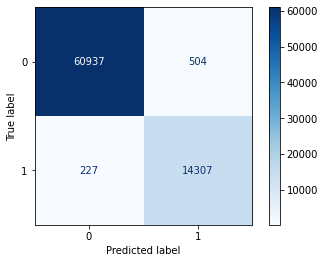

In [18]:
# using skf pipe, pred on val set

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

print(classification_report(y_val, 
                            y_pred, 
                            target_names = ['Non-subscriber', 'subscriber']))

plot_confusion_matrix(estimator=model, 
                      X=X_val, 
                      y_true=y_val, 
                      cmap='Blues'
                     )

* Pred on test set

                precision    recall  f1-score   support

Non-subscriber       1.00      0.99      0.99     61441
    subscriber       0.97      0.99      0.98     14534

      accuracy                           0.99     75975
     macro avg       0.98      0.99      0.99     75975
  weighted avg       0.99      0.99      0.99     75975



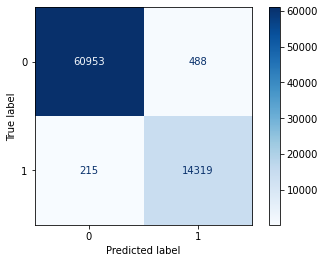

In [19]:
# using skf pipe, pred on test set

model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)

print(classification_report(y_test, 
                            y_test_pred, 
                            target_names = ['Non-subscriber', 'subscriber']))

plot_confusion_matrix(estimator=model, 
                      X=X_test, 
                      y_true=y_test, 
                      cmap='Blues'
                     )